In [1]:
import pandas as pd
import numpy as np
import os
import sys
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from granger.grangercausality_reg import *
from granger.grangercausality_cl import *
%load_ext autoreload
%autoreload 2
from db.database import DatabaseConnector
from dtloader.dataloader import DataLoader
from utils.utils import *
from utils.features_eng import *
from segmentation.segmentation import Segmentation
from failure_detector.failuredetector import *
from p4_analysis  import *
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import pearsonr
#Importing granger tests

In [2]:
dt = DataLoader()
ffiles = load_pickle('.','filtered_files.pickle')

mongodb://localhost:27017/
Database connected


In [3]:
resdf = load_pickle('.','signals_files_statistics.pickle')

In [11]:
len(resdf.loc [ (resdf.ATT == 1) & (resdf.CTUN == 1) & (resdf.unc_yaw == 1) ,:])

638

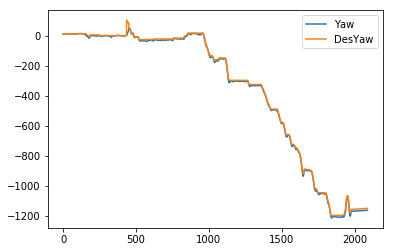

In [64]:
df = pd.DataFrame(dt.dbconnector.query('ATT'+'_'+'57ffe3cdbb9f806b20ca8c09')) 
df['Yaw'] = np.unwrap(df['Yaw'],280)
df['DesYaw'] = np.unwrap(df['DesYaw'],280)
df[['Yaw','DesYaw']].plot()
plt.show()

# Signals Granger

In [ ]:
d = {'RCOU': ['Ch1','Ch2','Ch3','Ch4','yaw_out'],
         'RCIN': ['C1','C2','C3', 'C4'],
         'MAG': ['MagX','MagY','MagZ','mag_field','mag_ofs'],
         'CTUN': ['ThrOut','ThrIn','DSAlt'],
         'GPS': ['Alt','Lat','Lng'],
         'ATT':['Pitch','Roll','ErrYaw'],
         'MODE': ['ModeNum'],
         'IMU':['GyrX','GyrY','GyrZ'],
         'BARO':['Alt'],
          'CURR':['Vcc','Volt']
         }
ucyaw_files = resdf.loc[resdf.unc_yaw == 1].index
dict_df = {}
for i,log in enumerate(ucyaw_files):
    print('File:{} --  {} / {}'.format(log,i,len(ucyaw_files)))
    # 1. get the index were in happened
    dftest, line_idx = get_yaw_event(
        log, dt, unwrap_thresh=280, undes_thresh=70)
    # 2. get the window for the yaw
    dftest_filtered = get_window_values(dftest, line_idx, win=600)
    # first part of the df for granger causality
    yaw_df = dftest_filtered.set_index('lineIndex')[['Yaw']]

    # 3. choose which the signals to check #4. create the df for the signal with lineindex as index
    init_dict = {}
    for k,val in d.items():
        for v in val:
            init_dict[k+'_'+v] = np.nan 

    for comp,sig in d.items():
        print('Processing: ',comp)
        df = pd.DataFrame(dt.dbconnector.query(comp+'_'+log))
        if len(df) <= 0:
            #signal does not exist here
            continue
        for s in sig:
            #check if s exists:
            print('\t Signal: ',s)
            try:
                if s == 'yaw_out':
                    df['yaw_out'] = df['Ch1'] + df['Ch2'] - (df['Ch4'] + df['Ch3'])
                    cause_df = df.set_index('lineIndex')[['yaw_out']]

                elif s == 'mag_field':
                    df[s] = np.sqrt(df.MagX**2+  df.MagY**2 +  df.MagZ**2)
                    cause_df = df.set_index('lineIndex')[[s]]

                elif s == 'mag_ofs':
                    df[s] = np.sqrt(df['OfsX']**2 + df['OfsY']**2 + df['OfsZ']**2)
                    cause_df = df.set_index('lineIndex')[[s]]
                else:
                    cause_df = df.set_index('lineIndex')[[s]]

                mlag,pval = test_signal(yaw_df,cause_df)
                if mlag == -1:
                    continue
                if pval <= 0.1:
                    init_dict[comp+'_'+s] = 1
                else:
                    init_dict[comp+'_'+s] = 0
            except:
                continue
    dict_df[log]  = init_dict.copy()


In [ ]:
save_as_pickle(dict_df,'.','granger672_results_signals.pickle')

In [ ]:
df_50 = pd.DataFrame(dict_df).T.loc[resdf.dropna().index]
(df_50.describe().loc['count']/50).sort_values(ascending=False).plot(kind='bar')

In [ ]:
(df_50.describe().loc['count']/50).sort_values(ascending=False)

In [ ]:
df_672 = pd.DataFrame(dict_df).T
l_counts_nonena = df_672.describe().loc['count']

In [ ]:
l_counts_nonena.plot(kind='bar')

In [ ]:
perc_sig = {}
for i,c in enumerate(df_672.columns):
    perc_sig[c] = np.sum(df_672.loc[df_672[c] == 1,c]) / l_counts_nonena[i]

In [ ]:
pd.DataFrame(perc_sig,index=[1]).T[1].sort_values(ascending=False).plot(kind='bar')

# Detect Rotations file list

In [ ]:
#check yaw > desyaw at 95% of datapoints 
#continous increase or decrease
#increasing differnce between yaw and desyaw 
df = pd.DataFrame(dt.dbconnector.query('ATT'+'_'+'56d75dd746a12d150ba9724f')) 
df['Yaw'] = np.unwrap(df['Yaw'],280)
df['DesYaw'] = np.unwrap(df['DesYaw'],280)
df[['Yaw','DesYaw']].plot()
plt.show()

In [ ]:
all_files = resdf.loc[resdf.unc_yaw ==1 ,:].index
for i,f in enumerate(all_files):
    if i % 100 == 0:
        print(i)
    try:
        df = pd.DataFrame(dt.dbconnector.query('ATT'+'_'+f))
        df_ctun = pd.DataFrame(dt.dbconnector.query('CTUN'+'_'+f)) 
        if len(df_ctun) <= 0:
            continue
        df['Yaw'] = np.unwrap(df['Yaw'],280)
        df['DesYaw'] = np.unwrap(df['DesYaw'],280)
        df['diff'] =  df['Yaw'] - df['DesYaw']
        #plt.figure(figsize=(10,8))
        sgmts_yawdiff = map_axis(df,segment_signal(df['diff'],10000000))
        #plot_segments_signal(df['diff'],sgmts_yawdiff,target=np.ones(len(sgmts_yawdiff)),title='Desyaw-yaw segmented')
        #plt.show()
        #cond 1
        slope_list = []
        for i,s in enumerate(sgmts_yawdiff):
            x1,y1,x2,y2 = s
            slope_list.append((y2 -y1) / (x2 - x1 ))
        slope_list = np.array(slope_list)
        if (sum(slope_list>0)/len(slope_list)) >= 0.8:
            #all are postive
            print('positive')
        elif (sum(slope_list<0)/ len(slope_list)) >= 0.8:
            #all are postive
            print('negative')
        else:
            continue
        #cond 2
        pos_cond = (sum(df['diff'] >  70) / len(df['diff']))  >= 0.90
        pos_neg = (sum(df['diff'] <  -70) / len(df['diff']))  >= 0.90
        if pos_cond or pos_neg:
            print('True')
        else:
            continue
        if sum(df_ctun['ThrOut'] > 0) > 0:
            print(f)
    except:
        print('Error')

# Detect Compass interference

In [ ]:
files_inter = resdf.loc[(resdf.unc_yaw ==1) & (resdf.MAG ==1) & (resdf.RCIN ==1)  & (resdf.GPS ==1) ,:]

In [50]:
win_corr = 800
for i,f in enumerate(['584b139a85e6364d0bb3f539']):
        if i % 50 == 0:
            print(i)
        #mag
        try:
            df,line_idx_pos = get_yaw_event(f,dt,undes_thresh=70) #added this now
            dmag = pd.DataFrame(dt.dbconnector.query('MAG'+'_'+f))
            dmag['field'] = np.sqrt(dmag.MagX**2+  dmag.MagY**2 +  dmag.MagZ**2)
#             sgmts_mag = map_axis(dmag,segment_signal(dmag['f ield'],400,err_growth=0.5))
#             target_mag = get_targets(sgmts_mag,line_idx_pos)
            dmag = dmag.set_index('lineIndex')
            #ctun
            df_ctun = pd.DataFrame(dt.dbconnector.query('CTUN'+'_'+f))
#             sgmts_ctun = map_axis(df_ctun,segment_signal(df_ctun['ThrOut'],400,err_growth=1))
#             target_ctun = get_targets(sgmts_ctun,line_idx_pos)
            df_ctun = df_ctun.set_index('lineIndex')
            x = df_ctun[(df_ctun.index >= line_idx_pos - win_corr) & (df_ctun.index <= line_idx_pos + win_corr)]['ThrOut']
            y = dmag[(dmag.index >= line_idx_pos - win_corr) & (dmag.index <= line_idx_pos + win_corr)]['field']
        except:
            print('Signal does not exist')
            continue
            
        if (sum(y >= 550)) >= 1 or (sum(y<= 120) >= 1):
            #correcting shapes
            if len(y) > len(x):
                y = y[0:len(x)]
            if len(y) < len(x):
                x = x[0:len(y)]

            #correlation betwee dmag and 
            r,p = pearsonr(y,x)
            if p <= 0.1: 
                print(f)
            else:
                print('failed')

0
failed


In [51]:
r

0.03488783609649757

In [52]:
p

0.8041294939749575

In [ ]:
p

In [ ]:
p

# Compass interference outer


In [ ]:
files_inter = resdf.loc[(resdf.unc_yaw ==1) & (resdf.MAG ==1) & (resdf.RCIN ==1)  & (resdf.GPS ==1) ,:]
win_corr = 800
for i,f in enumerate(files_inter.index):
        if i% 50 == 0:
            print(i)
        #mag
        df,line_idx_pos = get_yaw_event(f,dt,undes_thresh=70) #added this now
        dmag = pd.DataFrame(dt.dbconnector.query('MAG'+'_'+f))
        if len(dmag) <= 0:
            continue
        dmag['field'] = np.sqrt(dmag.MagX**2+  dmag.MagY**2 +  dmag.MagZ**2)
        dmag = dmag.set_index('lineIndex')

        #ctun
        df_ctun = pd.DataFrame(dt.dbconnector.query('CTUN'+'_'+f))
        if len(df_ctun) <= 0:
            continue
        df_ctun = df_ctun.set_index('lineIndex')
        try:
            x = df_ctun[(df_ctun.index >= line_idx_pos - win_corr) & (df_ctun.index <= line_idx_pos + win_corr)]['ThrOut']
            y = dmag[(dmag.index >= line_idx_pos - win_corr) & (dmag.index <= line_idx_pos + win_corr)]['field']
        except:
            continue

        try:
            #check average throttle values before 
            prev_thr_values = df_ctun[(df_ctun.index <= line_idx_pos)]['ThrOut'] 
            mean_thro = np.mean(prev_thr_values)
            std_thro = np.std(prev_thr_values)
            event_thr = df_ctun[(df_ctun.index > line_idx_pos)].iloc[0]['ThrOut'] 
            print(event_thr)
        except:
            continue
        if event_thr >= (mean_thro + std_thro) or event_thr <= (mean_thro - std_thro):
            continue
        else:
            print('normal throttle')

        #why contains high magnetic field
        if (sum(y >= 550)) >= 1 or (sum(y<= 120) >= 1):
            #correcting shapes
            if len(y) > len(x):
                y = y[0:len(x)]
            if len(y) < len(x):
                x = x[0:len(y)]

            #correlation betwee dmag and 
            r,p = pearsonr(y,x)
            if p > 0.1: 
                print(f) #no interference
            else:
                print('failed')
        else:
            print('failed')

In [ ]:
np.std(prev_thr_values)

In [ ]:
f

In [ ]:
lie

# Magnetic Field Threshold Testing

In [ ]:
#for i,log in enumerate(ffiles):
#    print('File:{} --  {} / {}'.format(log,i,len(ffiles)))
log = '57c57c7779eee4d643ad3406'
df,line_idx_pos = get_yaw_event(log,dt)
dmag = pd.DataFrame(dt.dbconnector.query('MAG'+'_'+log))

#offset calculation
dmag['ofs'] = np.sqrt(dmag['OfsX']**2 + dmag['OfsY']**2 + dmag['OfsZ']**2)
sgmts_ofs = map_axis(dmag,segment_signal(dmag['ofs'],0.1,err_growth=0))
target_ofs = get_targets(sgmts_ofs,line_idx_pos)

mag_field = True
if mag_field:
    dmag['field'] = np.sqrt(dmag.MagX**2+  dmag.MagY**2 +  dmag.MagZ**2)
    sgmts_mag = map_axis(dmag,segment_signal(dmag['field'],5,err_growth=0.1))

    #exact target
    target_mag_exact = get_targets(sgmts_mag,line_idx_pos)
    idx_magevent = np.argmax(target_mag_exact)

    if idx_magevent == 0:
        print('Event was the first event')
        print(np.mean(ofres[0:30]))

    win = 500
    while(True):
        #look at targets before and after and compare 
        target_mag = get_targets(sgmts_mag,line_idx_pos,upper_window=win,lower_window=win) #the segments found within the window
        #cchecking for the number of segments found
        #first segment from below
        idx_below = np.argmax(target_mag) #first 1 found
        #how many segments between the event and below: 
        idx_above = np.argmin(target_mag[idx_magevent:])+len(target_mag[:idx_magevent-1])
        num_seg_below =abs(idx_below -  idx_magevent) 
        num_seg_above =abs(idx_above -  idx_magevent) 
        if (num_seg_below)  >= 4 and (num_seg_above >= 4): #if number of segments is not at least 2 increase window
            break
        else:
            win += 50
        if win > 2000:
            print('window reach max.. no convergence')
            break

    sgmnts_below = sgmts_mag[idx_below:idx_magevent+1]
    sgmnts_above = sgmts_mag[idx_magevent:idx_above]
    pvalue = high_mgfield_detect(sgmnts_below,sgmnts_above)[1]
    if pvalue < 0.05:
        print('Sig difference !')
    else:
        print(f'no sig : {pvalue}')
    dmag = dmag.set_index('lineIndex')
    plt.figure(figsize=(10,8))
    plt.plot(dmag['field'])
    plot_segments_signal(dmag['field'] ,sgmts_mag,target = target_mag,title='Mag field')
    plt.show()



#ofset target check
x1,y1,x2,y2 = sgmts_ofs[np.argmax(target_ofs)]
if y1 == y2:
    print('No change -> no interfernce caused at that moment in time')
    if y1 > 150:
        print('High interference value')
else:
    print('interference occured !')

plt.figure(figsize=(10,8))
dmag['ofs'].plot(title='offsets')
plot_segments_signal(dmag['ofs'] ,sgmts_ofs,target = target_ofs,title='ofs inter')

# Plot All

In [ ]:
comp = 'ATT'
for i,log in enumerate(ffiles):
    print('File:{} --  {} / {}'.format(log,i,len(ffiles)))
    filename = log

    #DESYAW
    df = pd.DataFrame(dt.dbconnector.query(comp+'_'+filename))

    #RCOUT
    df_rcout = pd.DataFrame(dt.dbconnector.query('RCOU'+'_'+filename))

    #RCIN    
    df_rcin = pd.DataFrame(dt.dbconnector.query('RCIN'+'_'+filename))
    #MODE
    sr_mode = corr_var(filename,dt,{'MODE':['ModeNum'],'ATT':['DesYaw']},find_corr=False).reset_index()['MODE_ModeNum']
    
    #RCOU_Total
    df_rcout['total_out'] = df_rcout['Ch1'] +  df_rcout['Ch2'] - (df_rcout['Ch4'] +  df_rcout['Ch3'])

    #fixing the yaw and plotting
    df['Yaw'] = np.unwrap(df['Yaw'],280)
    df['DesYaw'] = np.unwrap(df['DesYaw'],280)
    if  sum(abs(df['Yaw'] - df['DesYaw']) > 70)  >= 1:
        df[['Yaw','DesYaw']].plot(figsize=(10,8))
        plt.show()
    err_frame = pd.DataFrame(dt.dbconnector.query('ERR'+'_'+filename))
    if len(err_frame) > 0:
        print(f'{filename} has a error file')

# Single File Analysis

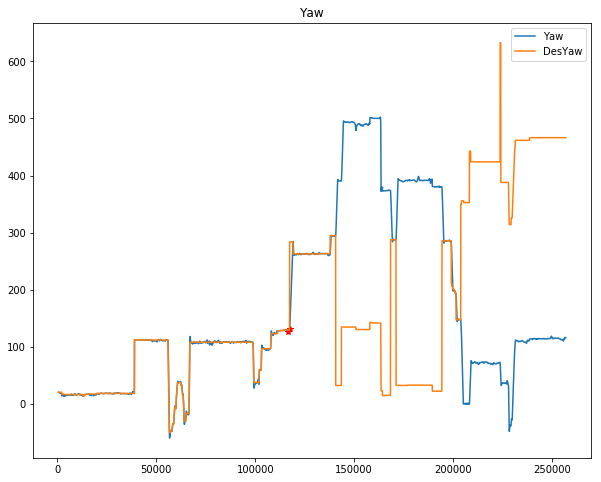

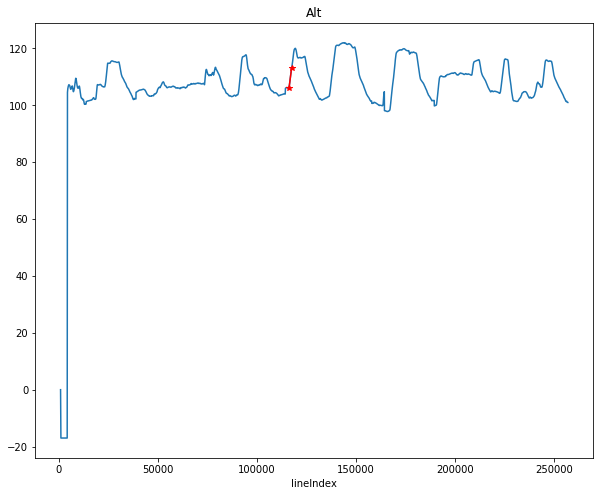

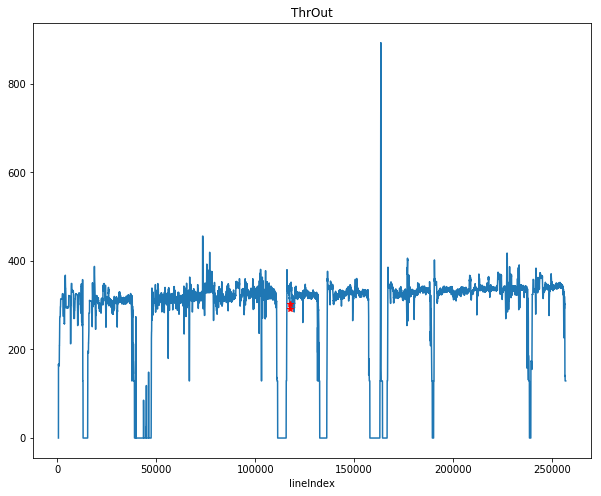

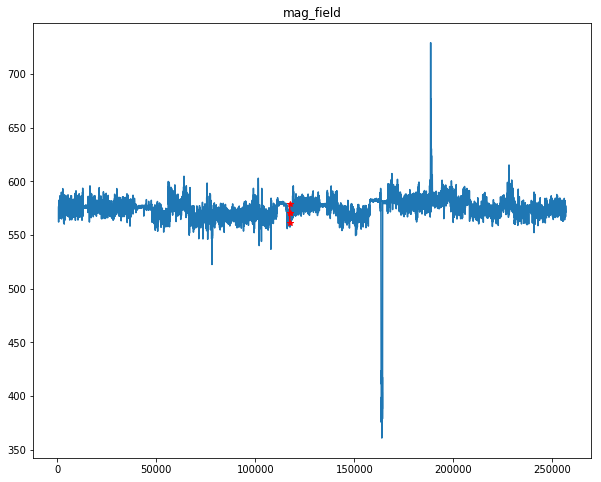

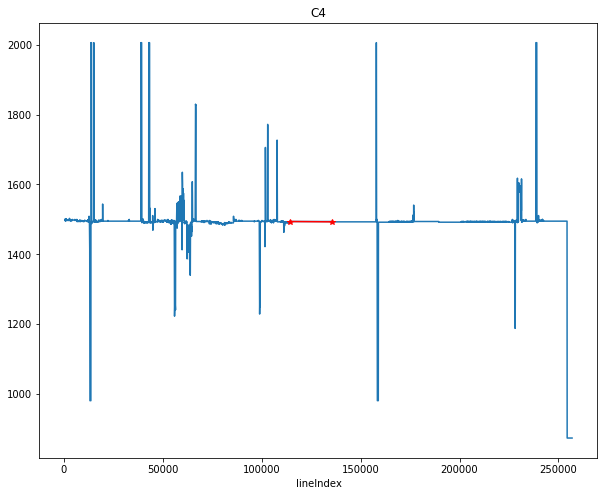

KeyboardInterrupt: 

<Figure size 720x576 with 0 Axes>

In [42]:
file_detect = '58175404ce5002c15002807e'
#First Change in Yaw detection
df,line_idx_pos = get_yaw_event(file_detect,dt,undes_thresh=70)
#Plotting
sgmts_yaw = map_axis(df,segment_signal(df['Yaw'],20))
target_yaw = get_targets(sgmts_yaw,line_idx_pos,upper_window=0)
#changing the index before plotting to have it on the same axis
df = df.set_index('lineIndex')
plt.figure(figsize=(10,8))
plt.plot(df['Yaw'])
#map the segments
plot_segments_signal(df['Yaw'],sgmts_yaw,target = target_yaw,title='Yaw')
plt.plot(df['DesYaw'],label='DesYaw')
plt.legend()
plt.show()
#-------------#-------------#-------------#-------------#-------------#-------------#-------------
#Alt
plot_sig_lineidx('GPS','Alt',dt,line_idx_pos,file_detect,err=1)
#Throttle Out
sg_throut,df_ctun = plot_sig_lineidx('CTUN','ThrOut',dt,line_idx_pos,file_detect,err=10)


#Magnetic field
plt.figure(figsize=(10,8))
dmag = pd.DataFrame(dt.dbconnector.query('MAG'+'_'+file_detect))
dmag['field'] = np.sqrt(dmag.MagX**2+  dmag.MagY**2 +  dmag.MagZ**2)
sgmts_mag = map_axis(dmag,segment_signal(dmag['field'],20,err_growth=0.1))
target_mag = get_targets(sgmts_mag,line_idx_pos)
dmag = dmag.set_index('lineIndex')
plt.plot(dmag['field'])
plot_segments_signal(dmag['field'] ,sgmts_mag,target = target_mag,title='mag_field')


#RCIN
plot_sig_lineidx('RCIN','C4',dt,line_idx_pos,file_detect,err=10)
plot_sig_lineidx('RCIN','C3',dt,line_idx_pos,file_detect,err=10)
#MODE
plot_sig_lineidx('MODE','ModeNum',dt,line_idx_pos,file_detect,err=1)

#RCOU
plt.figure(figsize=(10,8))
df_rcout = pd.DataFrame(dt.dbconnector.query('RCOU'+'_'+ file_detect))
df_rcout['total_out'] = df_rcout['Ch1'] +  df_rcout['Ch2'] - (df_rcout['Ch4'] +  df_rcout['Ch3'])
sgmts_tot = map_axis(df_rcout,segment_signal(df_rcout['total_out'],20))
target_tot = get_targets(sgmts_tot,line_idx_pos)
df_rcout = df_rcout.set_index('lineIndex')
plt.plot(df_rcout['total_out'])
plot_segments_signal(df_rcout['total_out'],sgmts_tot,target = target_tot,title='Total_Out')
plt.show() 
#---------------------------------------------------



# #Magnetic offset
# plt.figure(figsize=(10,8))
# dmag = pd.DataFrame(dt.dbconnector.query('MAG'+'_'+file_detect))
# dmag['field'] = np.sqrt(dmag.MagX**2+  dmag.MagY**2 +  dmag.MagZ**2)
# sgmts_ofs = map_axis(dmag,segment_signal(dmag['field'],400,err_growth=1))
# target_ofs = get_targets(sgmts_ofs,line_idx_pos)
# dmag = dmag.set_index('lineIndex')
# plt.plot(dmag['field'])
# plot_segments_signal(dmag['field'] ,sgmts_ofs,target = target_ofs,title='field')

# #Error Codes if exists
# dftest = pd.DataFrame(dt.dbconnector.query('ERR_' + file_detect))
# if len(dftest) > 0:
#     plt.scatter(x=dftest['lineIndex'],y=dftest['Subsys'])
#     plt.show()

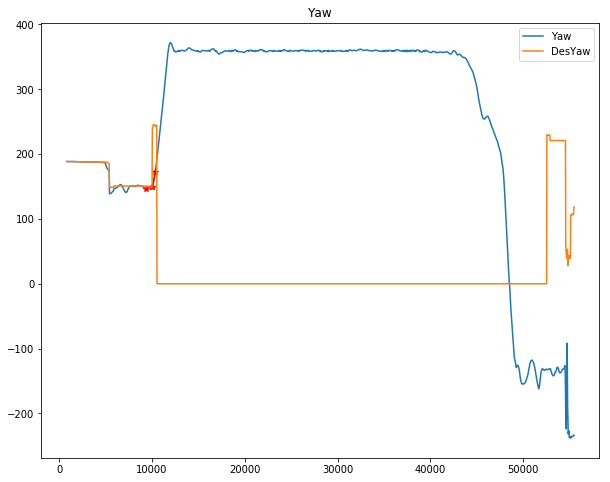

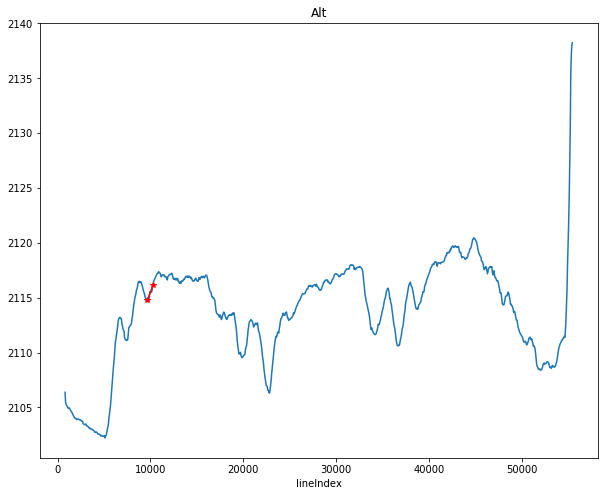

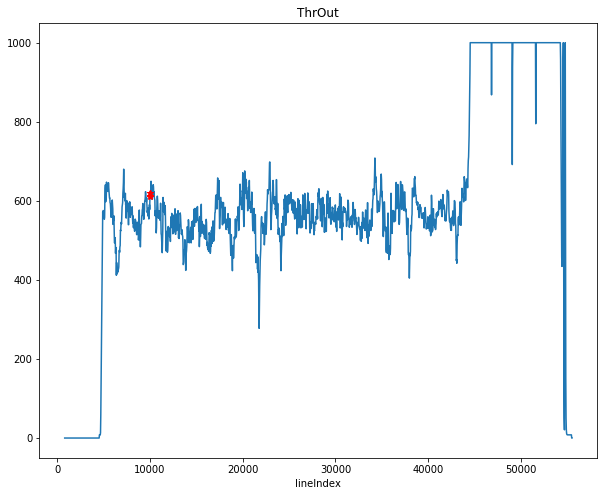

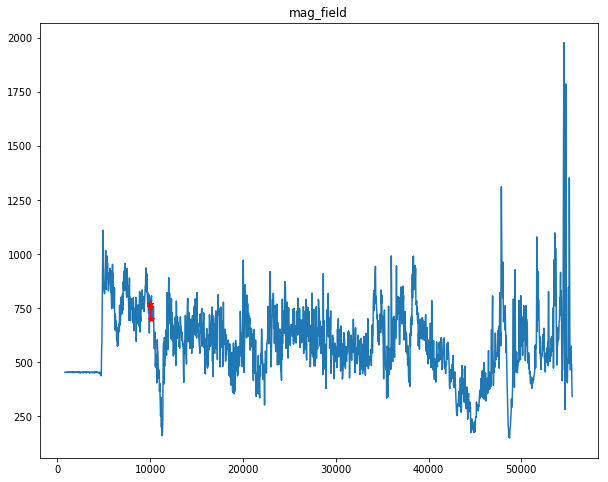

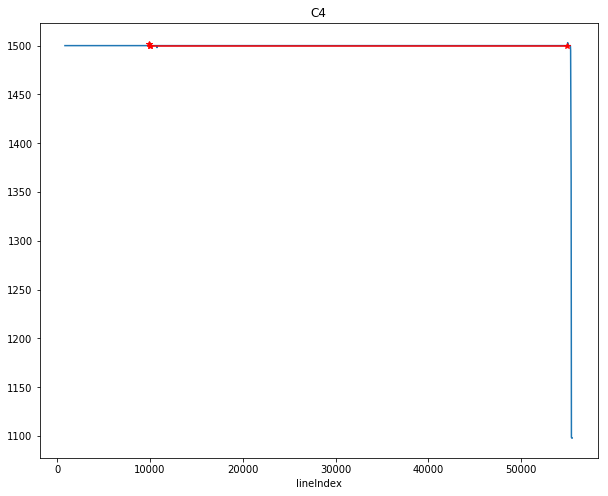

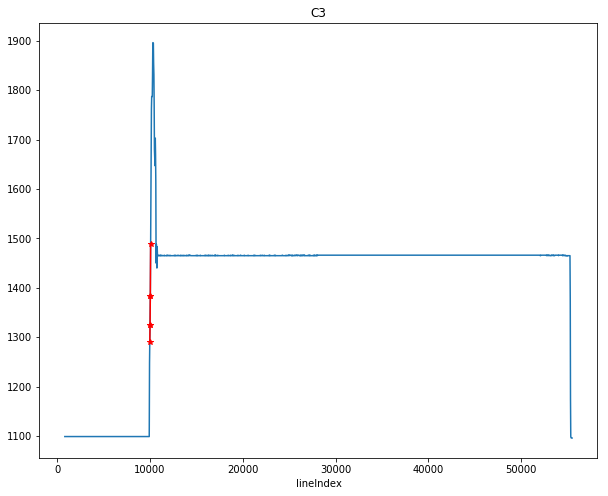

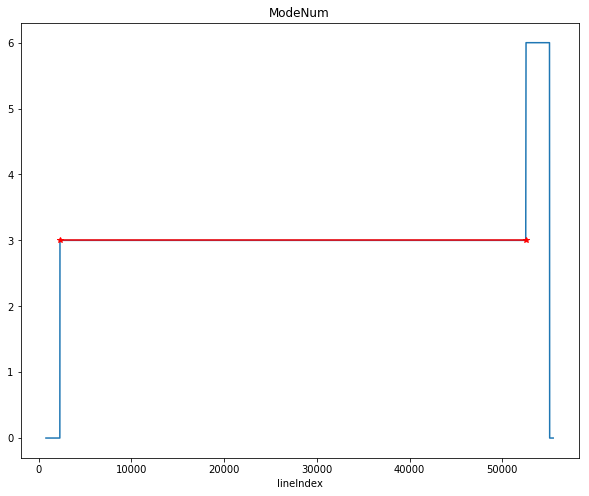

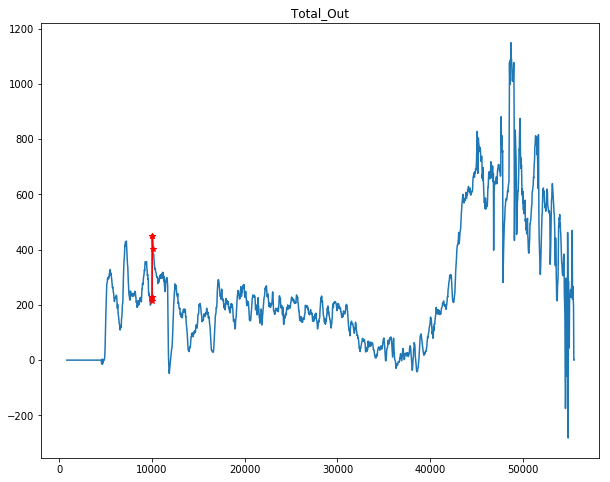

In [56]:
file_detect = '584b139a85e6364d0bb3f539'
#First Change in Yaw detection
df,line_idx_pos = get_yaw_event(file_detect,dt,undes_thresh=70)
#Plotting
sgmts_yaw = map_axis(df,segment_signal(df['Yaw'],20))
target_yaw = get_targets(sgmts_yaw,line_idx_pos,upper_window=0)
#changing the index before plotting to have it on the same axis
df = df.set_index('lineIndex')
plt.figure(figsize=(10,8))
plt.plot(df['Yaw'])
#map the segments
plot_segments_signal(df['Yaw'],sgmts_yaw,target = target_yaw,title='Yaw')
plt.plot(df['DesYaw'],label='DesYaw')
plt.legend()
plt.show()
#-------------#-------------#-------------#-------------#-------------#-------------#-------------
#Alt
plot_sig_lineidx('GPS','Alt',dt,line_idx_pos,file_detect,err=1)
#Throttle Out
sg_throut,df_ctun = plot_sig_lineidx('CTUN','ThrOut',dt,line_idx_pos,file_detect,err=10)


#Magnetic field
plt.figure(figsize=(10,8))
dmag = pd.DataFrame(dt.dbconnector.query('MAG'+'_'+file_detect))
dmag['field'] = np.sqrt(dmag.MagX**2+  dmag.MagY**2 +  dmag.MagZ**2)
sgmts_mag = map_axis(dmag,segment_signal(dmag['field'],20,err_growth=0.1))
target_mag = get_targets(sgmts_mag,line_idx_pos)
dmag = dmag.set_index('lineIndex')
plt.plot(dmag['field'])
plot_segments_signal(dmag['field'] ,sgmts_mag,target = target_mag,title='mag_field')


#RCIN
plot_sig_lineidx('RCIN','C4',dt,line_idx_pos,file_detect,err=10)
plot_sig_lineidx('RCIN','C3',dt,line_idx_pos,file_detect,err=10)
#MODE
plot_sig_lineidx('MODE','ModeNum',dt,line_idx_pos,file_detect,err=1)

#RCOU
plt.figure(figsize=(10,8))
df_rcout = pd.DataFrame(dt.dbconnector.query('RCOU'+'_'+ file_detect))
df_rcout['total_out'] = df_rcout['Ch1'] +  df_rcout['Ch2'] - (df_rcout['Ch4'] +  df_rcout['Ch3'])
sgmts_tot = map_axis(df_rcout,segment_signal(df_rcout['total_out'],20))
target_tot = get_targets(sgmts_tot,line_idx_pos)
df_rcout = df_rcout.set_index('lineIndex')
plt.plot(df_rcout['total_out'])
plot_segments_signal(df_rcout['total_out'],sgmts_tot,target = target_tot,title='Total_Out')
plt.show() 
#---------------------------------------------------



# #Magnetic offset
# plt.figure(figsize=(10,8))
# dmag = pd.DataFrame(dt.dbconnector.query('MAG'+'_'+file_detect))
# dmag['field'] = np.sqrt(dmag.MagX**2+  dmag.MagY**2 +  dmag.MagZ**2)
# sgmts_ofs = map_axis(dmag,segment_signal(dmag['field'],400,err_growth=1))
# target_ofs = get_targets(sgmts_ofs,line_idx_pos)
# dmag = dmag.set_index('lineIndex')
# plt.plot(dmag['field'])
# plot_segments_signal(dmag['field'] ,sgmts_ofs,target = target_ofs,title='field')

# #Error Codes if exists
# dftest = pd.DataFrame(dt.dbconnector.query('ERR_' + file_detect))
# if len(dftest) > 0:
#     plt.scatter(x=dftest['lineIndex'],y=dftest['Subsys'])
#     plt.show()

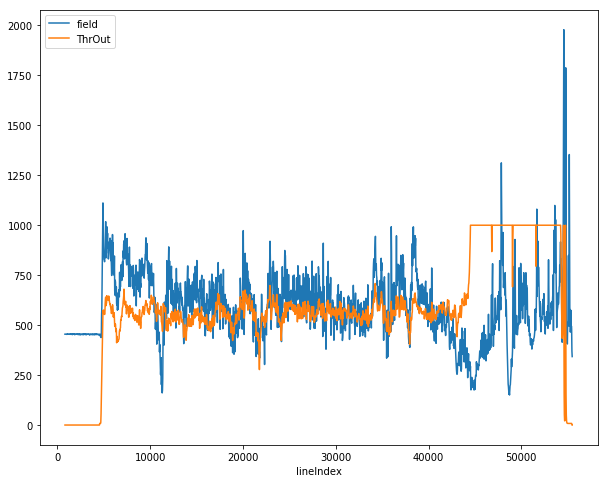

In [57]:
plt.figure(figsize=(10,8))
dmag['field'].plot()
df_ctun['ThrOut'].plot()
plt.legend()

In [62]:
pearsonr(dmag['field'].iloc[:1500],df_ctun['ThrOut'].iloc[:1500])

(0.32222953656259884, 1.3906336248418094e-37)